<ipython-input-15-87e10acb9828>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Premium'] = data['Premium'].replace({'yes': 1, 'no': 0})


Output()

Output()

Output()

          mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha   38.437  9.942    18.848     56.951      0.169    0.123    3453.0   
beta1   15.486  0.679    14.221     16.921      0.015    0.010    2194.0   
beta2  222.778  6.410   210.049    235.164      0.140    0.099    2094.0   
beta3   19.709  9.696     2.885     40.297      0.165    0.118    3472.0   
sigma  317.097  4.772   307.152    326.121      0.087    0.061    3030.0   

       ess_tail  r_hat  
alpha    2526.0    1.0  
beta1    2340.0    1.0  
beta2    2325.0    1.0  
beta3    2135.0    1.0  
sigma    2915.0    1.0  
95% HDI pentru beta1: <xarray.Dataset> Size: 64B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    beta1    (hdi) float64 16B 14.22 16.92
95% HDI pentru beta2: <xarray.Dataset> Size: 64B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    beta2    (hdi) float64 16B 210.0 235.2


<ipython-input-15-87e10acb9828>:51: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pm.hdi(mu_pred, hdi_prob=0.90)


Interval HDI 90% pentru pretul expected: [[1951.48909593 1953.22294314]
 [1947.06001182 1968.24267579]
 [1945.37276879 1982.80819859]
 ...
 [1914.64290906 1952.78478375]
 [1943.46894265 1998.54695808]
 [1958.06710572 1962.72472217]]
Interval de predictie HDI 90%: [1338.84575872 2977.27863082]
HDI 95% pentru beta3: <xarray.Dataset> Size: 64B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    beta3    (hdi) float64 16B 2.885 40.3


<Axes: title={'center': 'beta3'}>

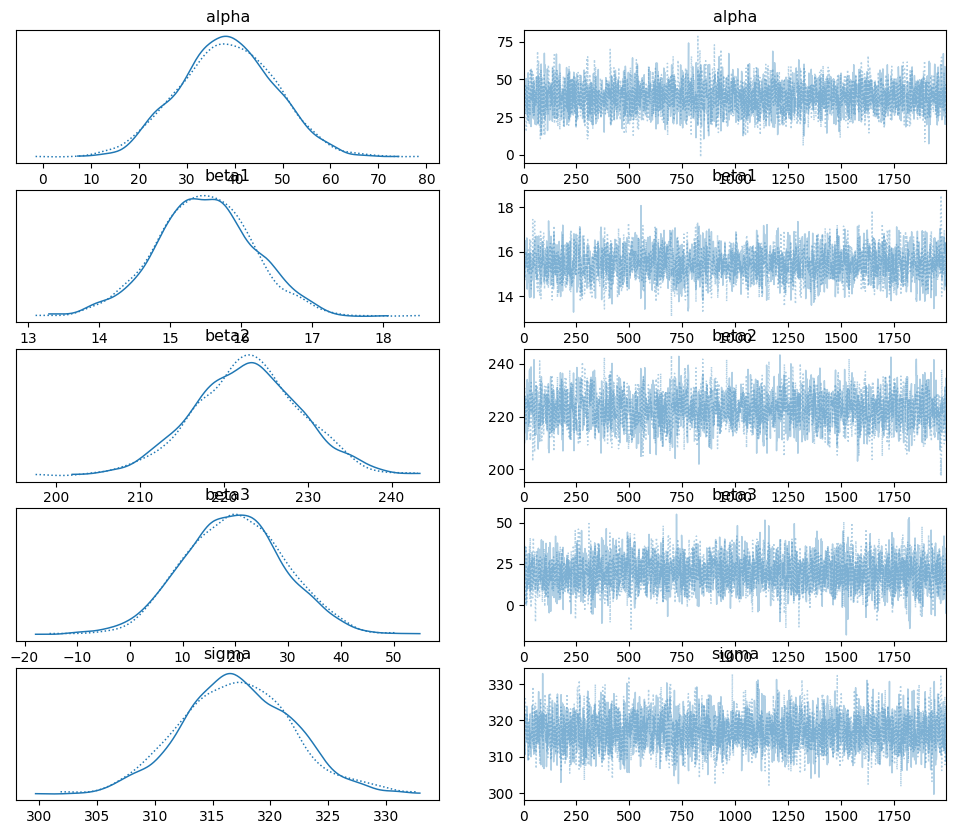

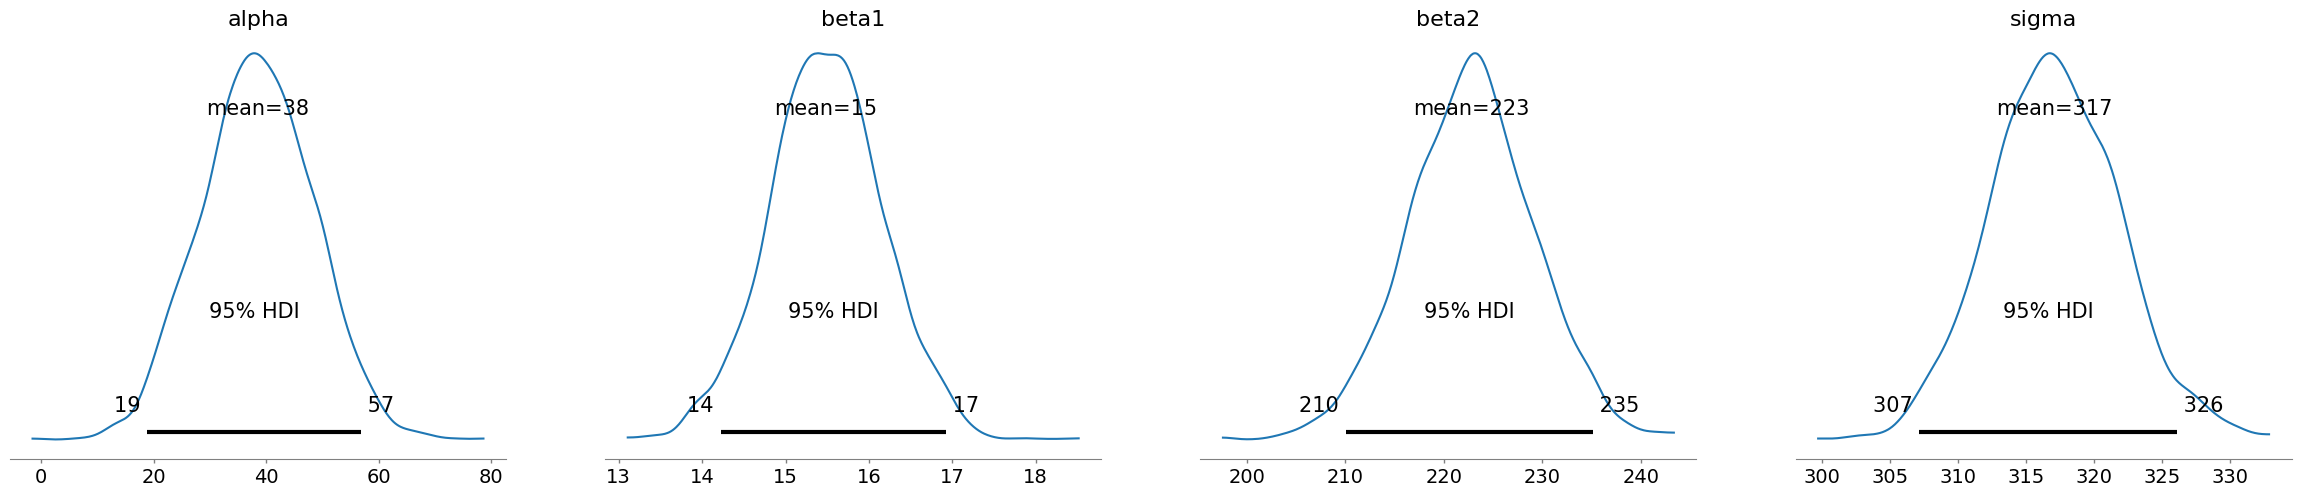

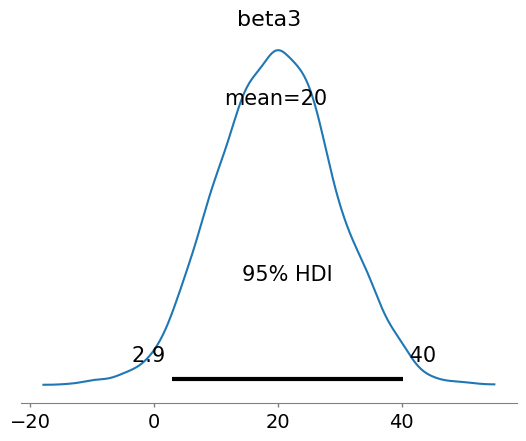

In [15]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("Prices.csv")

# y ∼ N (μ, σ), y=preţul de vânzare
#μ = α + β1x1 + β2x2, x1=frecvenţa procesorului x2=ln al mărimii hard diskului

data['Premium'] = data['Premium'].replace({'yes': 1, 'no': 0})
log_hd = np.log(data['HardDrive'])

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)  # coef pt frecventa
    beta2 = pm.Normal("beta2", mu=0, sigma=10) # coef pt log marimii hard disk
    sigma = pm.HalfNormal("sigma", sigma=10)
    beta3 = pm.Normal('beta3', mu=0, sigma=10)  # coef pt premium

    # μ = α + β1x1 + β2x2
    mu = alpha + beta1 * data['Speed'] + beta2 * log_hd
    mu += beta3 * data['Premium']


    # likelihood
    price_obs = pm.Normal("price_obs", mu=mu, sigma=sigma, observed=data["Price"])
    trace = pm.sample(5000, return_inferencedata=True, random_seed=42)
summary = az.summary(trace, hdi_prob=0.95)
az.plot_trace(trace)
print(summary)

# estibari 95% HDI pentru beta1 și beta2
hdi_beta1 = az.hdi(trace, var_names=["beta1"], hdi_prob=0.95)
hdi_beta2 = az.hdi(trace, var_names=["beta2"], hdi_prob=0.95)
az.plot_posterior(trace, var_names=["alpha", "beta1", "beta2", "sigma"], hdi_prob=0.95)
print("95% HDI pentru beta1:", hdi_beta1)
print("95% HDI pentru beta2:", hdi_beta2)

#exercitiul 4
Speed = 33
HardDrive = 540
with model:
  #posterior predictive check pt extragerea valorilor predictiilor
    ppc = pm.sample_posterior_predictive(trace, var_names=['price_obs'])

price_predictions = ppc.posterior_predictive["price_obs"].values
mu_pred = trace.posterior['alpha'].values + trace.posterior['beta1'].values * Speed + trace.posterior['beta2'].values * np.log(HardDrive)
hdi = pm.hdi(mu_pred, hdi_prob=0.90)
print(f"Interval HDI 90% pentru pretul expected: {hdi}")


#exericitul 5
price_predictions = ppc.posterior_predictive["price_obs"].values.flatten() # .flatten() pentru a obtine un array 1d

# pt pretul prezis interval est 90%
hdi = pm.hdi(price_predictions, hdi_prob=0.90)

print(f"Interval de predictie HDI 90%: {hdi}")

#exercitiul 6
# HDI pentru beta3
hdi_beta3 = pm.hdi(trace.posterior['beta3'], hdi_prob=0.95)
print(f"HDI 95% pentru beta3: {hdi_beta3}")
az.plot_posterior(trace, var_names=["beta3"], hdi_prob=0.95)


3. Pe baza rezultatelor obţinute, sunt frecvenţa procesorului şi mărimea hard diskului predictori utili ai preţului de vânzare?
Daca HDI contine valoarea 0 => nu are un efect foarte mare
Daca nu contine val 0 => are un efect mare
Ambii parametri sunt utili in prezicerea pretului de vanzare a unui pc

6. Afectează în vreun fel preţul faptul că producătorul este premium? Justificaţi.

Nu, deoarece conform HDI de 95%  pt beta 3 avem o crestere foarte mica (20 de lei)
